Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')


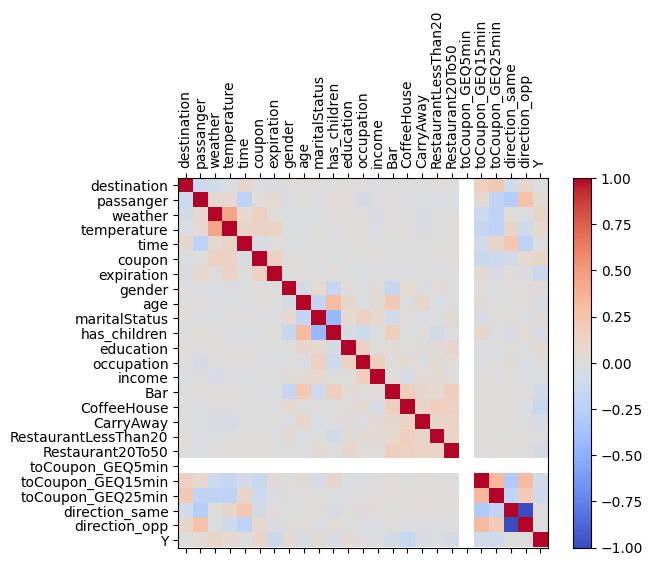

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Ocena:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1059
           1       0.65      0.76      0.70      1478

    accuracy                           0.63      2537
   macro avg       0.61      0.60      0.60      2537
weighted avg       0.62      0.63      0.61      2537

Random Forest Ocena:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1059
           1       0.76      0.83      0.79      1478

    accuracy                           0.74      2537
   macro avg       0.74      0.73      0.73      2537
weighted avg       0.74      0.74      0.74      2537

SVM Ocena:
              precision    recall  f1-score   support

           0       0.61      0.11      0.19      1059
           1       0.60      0.95      0.73      1478

    accuracy                           0.60      2537
   macro avg       0.60      0.53      0.46      2537
weighted avg   

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:47:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)


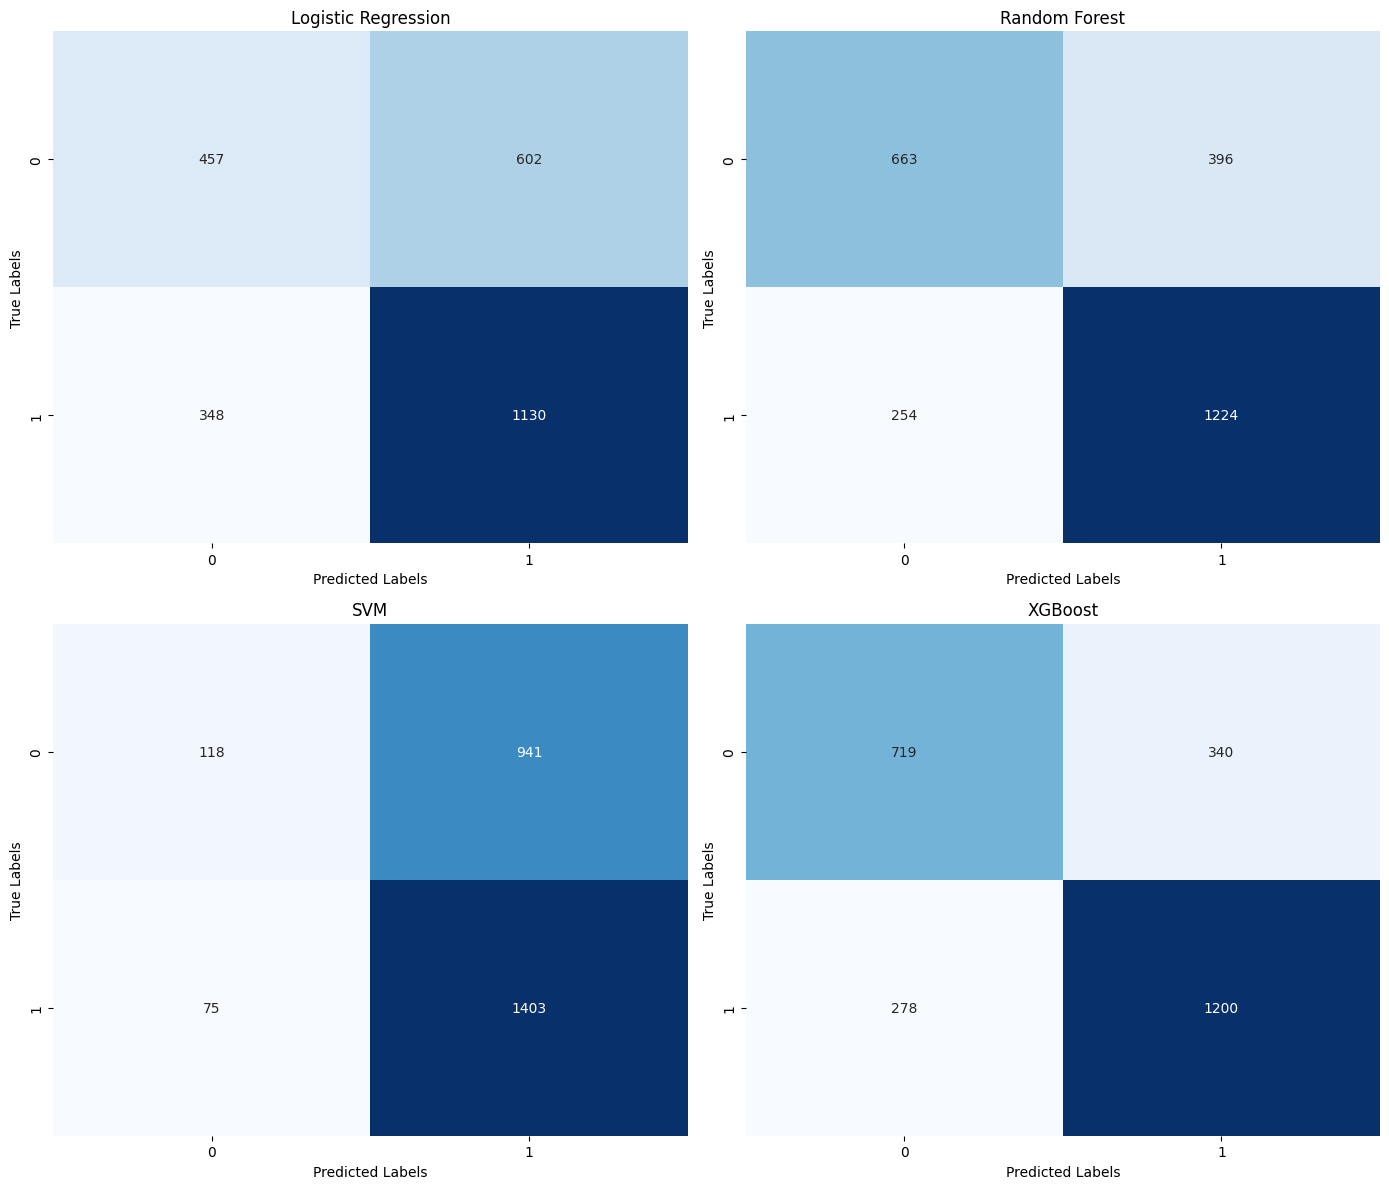

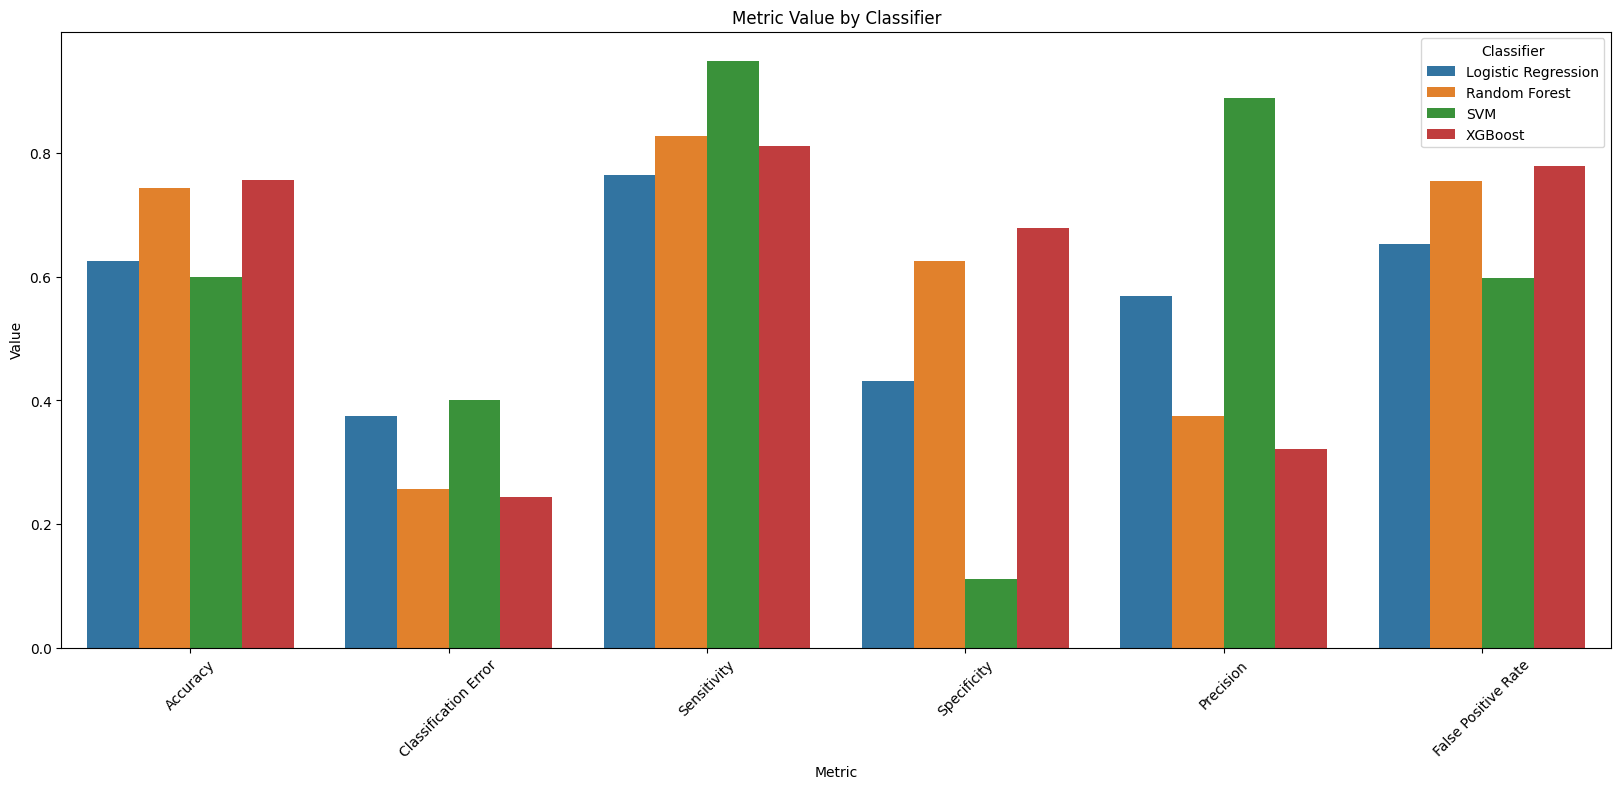

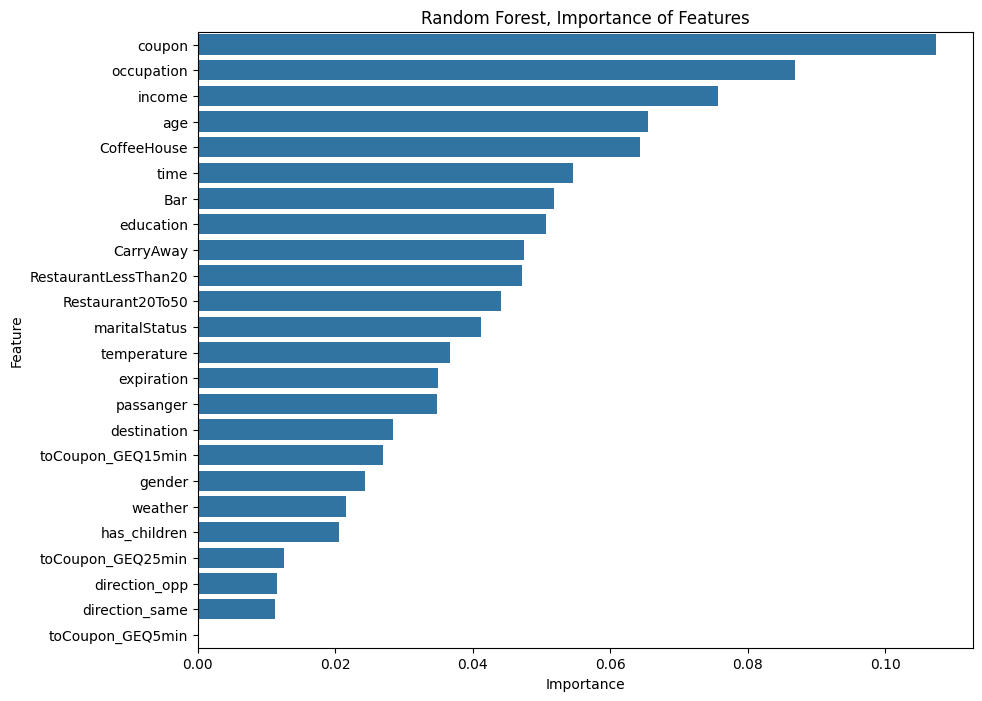

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import svm
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# link do bazy danych
# https://www.kaggle.com/datasets/henryshan/amazon-survey-coupon-recommendation-dataset/data

df = pd.read_csv("coupon.csv")

pd.set_option('display.max_columns', None)

# Wyświetl nazwy kolumn
print(df.columns)

# Usuń kolumnę 'car'
df.drop('car', axis=1, inplace=True)

# Uzupełnienei brakujących wartości
for column in ['Bar', 'CarryAway', 'CoffeeHouse', 'RestaurantLessThan20', 'Restaurant20To50']:
    df[column] = df[column].fillna(df[column].mode()[0])

# Modyfikacja kolumny Time
time_to_part_of_day = {
    '2PM': 'popołudnie',
    '10AM': 'rano',
    '6PM': 'wieczór',
    '7AM': 'wczesny_ranek',
    '10PM': 'noc'
}
df['time'] = df['time'].map(time_to_part_of_day)

# Encoder dla zmiennych kategorycznych
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Identyfikacja kolumn kategorycznych
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Utwórz instancję ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')

# Generowanie macierzy korelacji
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(df.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

# Podział zbioru danych na treningowy i testowy
X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Funkcja do obliczania i wyświetlania metryk
def calculate_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    classification_error = 1 - accuracy
    sensitivity = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    false_positive_rate = 1 - specificity
    precision = precision_score(y_test, y_pred)
    return accuracy, classification_error, sensitivity, specificity, false_positive_rate, precision

# Funkcja do trenowania i oceny klasyfikatora
def train_and_evaluate_classifier(clf, X_train, y_train, X_test, y_test, classifier_name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    print(f"{classifier_name} Ocena:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

# Trenowanie i ocena regresji logistycznej
metrics_lr, cm_lr = train_and_evaluate_classifier(LogisticRegression(), X_train, y_train, X_test, y_test, "Logistic Regression")

# Trenowanie i ocena lasu losowego
clf_rf = RandomForestClassifier(n_estimators=100, random_state=101)
metrics_rf, cm_rf = train_and_evaluate_classifier(clf_rf, X_train, y_train, X_test, y_test, "Random Forest")

# Trenowanie i ocena SVM
metrics_svm, cm_svm = train_and_evaluate_classifier(svm.SVC(), X_train, y_train, X_test, y_test, "SVM")

# Trenowanie i ocena XGBoost
clf_xgb = XGBClassifier(eta=0.5, max_leaf_nodes=10)
metrics_xgb, cm_xgb = train_and_evaluate_classifier(clf_xgb, X_train, y_train, X_test, y_test, "XGBoost")






# Wykres wszystkich macierzy na jednym wykresie
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

def plot_confusion_matrix(cm, ax, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')

plot_confusion_matrix(cm_lr, axes[0, 0], 'Logistic Regression')
plot_confusion_matrix(cm_rf, axes[0, 1], 'Random Forest')
plot_confusion_matrix(cm_svm, axes[1, 0], 'SVM')
plot_confusion_matrix(cm_xgb, axes[1, 1], 'XGBoost')

plt.tight_layout()
plt.show()


# Ramka danych wykorzystana w wykresie porównującym algorytmy
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Classification Error', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate'],
    'Logistic Regression': metrics_lr,
    'Random Forest': metrics_rf,
    'SVM': metrics_svm,
    'XGBoost': metrics_xgb
})

# Wykres porównawczy wykorzystanych algorytmów
metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Classifier', value_name='Value')

plt.figure(figsize=(20, 8))
sns.barplot(x='Metric', y='Value', hue='Classifier', data=metrics_df_melted)
plt.title('Metric Value by Classifier')
plt.xticks(rotation=45)
plt.show()


# Ważność cech dla lasu losowego
importances = clf_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Wykres ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Random Forest, Importance of Features')
plt.show()



In [3]:
!pip freeze > requirements.txt


In [2]:
pip install --upgrade --force-reinstall pandas


Note: you may need to restart the kernel to use updated packages.Collecting pandas
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 1.7 MB/s eta 0:00:07
   -- ------------------------------------- 0.8/11.5 MB 1.7 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.5 MB 1.7 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.5 MB 1.7 MB/s eta 0:00:06
   ------- -------------------------------- 2.1/11.5 MB 1.9 MB/s eta 0:00:06
   --------- ------------------------------ 2.6/11.5 MB 2.0 MB/s eta 0:00:05
   ---------- ----------------------------- 3.1/11.5 MB 2.0 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/11.5 MB 2.1 MB/s eta 0:00:04
   -------------- ------------------------- 4.2/11.5 MB 2.2 MB/s eta 0:00:04
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.2 which is incompatible.
osmnx 1.9.4 requires numpy<1.27,>=1.20, but you have numpy 2.2.2 which is incompatible.
scipy 1.12.0 requires numpy<1.29.0,>=1.22.4, but you have numpy 2.2.2 which is incompatible.
streamlit 1.28.2 requires numpy<2,>=1.19.3, but you have numpy 2.2.2 which is incompatible.
streamlit 1.28.2 requires packaging<24,>=16.8, but you have packaging 24.0 which is incompatible.
streamlit 1.28.2 requires pillow<11,>=7.1.0, but you have pillow 11.0.0 which is incompatible.
tensorflow-intel 2.16.1 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.2 which is incompatible.


In [4]:
pip install pipreqs


Note: you may need to restart the kernel to use updated packages.


In [6]:
pipreqs "C:\Users\Michał i Paweł\Desktop\elo\Python_ML\Machine_Learning(RF,XGBOOST,SVM)"



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (451365518.py, line 1)

In [7]:
!pipreqs "C:/Users/Michał i Paweł/Desktop/elo/Python_ML_Machine_Learning(RF,XGBOOST,SVM)" --force


INFO: Not scanning for jupyter notebooks.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Scripts\pipreqs.exe\__main__.py", line 7, in <module>
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 609, in main
    init(args)
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 599, in init
    generate_requirements_file(path, imports, symbol)
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 209, in generate_requirements_file
    with _open(path, "w") as out_file:
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "

In [8]:
!pipreqs "C:/Users/Michał i Paweł/Desktop/elo/Python_ML_Machine_Learning(RF,XGBOOST,SVM)" --force


INFO: Not scanning for jupyter notebooks.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Scripts\pipreqs.exe\__main__.py", line 7, in <module>
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 609, in main
    init(args)
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 599, in init
    generate_requirements_file(path, imports, symbol)
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\pipreqs\pipreqs.py", line 209, in generate_requirements_file
    with _open(path, "w") as out_file:
  File "C:\Users\Michał i Paweł\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "